In [1]:
import pandas as pd
import numpy as np
import random
from datetime import datetime, timedelta

# Set seed for reproducibility
np.random.seed(42)
random.seed(42)

def generate_messy_data(n_rows=1000):
    print(f"Generating {n_rows} rows of synthetic marketing data...")

    # 1. Base Data Generation
    ids = [f"CMP-{x:05d}" for x in range(1, n_rows + 1)]

    # Create messy dates (Mixed formats)
    start_date = datetime(2023, 1, 1)
    dates = []
    for _ in range(n_rows):
        d = start_date + timedelta(days=random.randint(0, 365))
        # Scenario 2: Mixed Date Formats
        if random.random() < 0.1:
            dates.append(d.strftime("%d/%m/%Y")) # European format string
        elif random.random() < 0.1:
            dates.append(d.strftime("%Y-%m-%d")) # ISO format string
        else:
            dates.append(d) # Actual datetime object

    # Channels with typos (Scenario 3)
    channels_base = ['Facebook', 'Instagram', 'Google Ads', 'TikTok', 'Email']
    channels = []
    for _ in range(n_rows):
        ch = random.choice(channels_base)
        if random.random() < 0.05: # 5% chance of typo
            typos = {'Facebook': 'Facebok', 'Instagram': 'Insta_gram', 'Google Ads': 'Gogle', 'TikTok': 'Tik_Tok', 'Email': 'E-mail'}
            ch = typos.get(ch, ch)
        channels.append(ch)

    # 2. Metrics Generation
    impressions = np.random.randint(1000, 100000, size=n_rows)
    clicks = (impressions * np.random.uniform(0.01, 0.05, size=n_rows)).astype(int)
    spend = (clicks * np.random.uniform(0.5, 2.0, size=n_rows)).round(2)
    conversions = (clicks * np.random.uniform(0.05, 0.2, size=n_rows)).astype(int)

    # Create DataFrame
    df = pd.DataFrame({
        'Campaign ID': ids,
        'Campaign_Name': [f"Q{random.choice([1,2,3,4])}_{random.choice(['Summer', 'Winter', 'BlackFriday', 'Launch'])}_{x}" for x in ids], # Scenario 6: Nested info
        'Start_Date': dates,
        'End_Date': [d + timedelta(days=random.randint(1, 30)) if isinstance(d, datetime) else pd.to_datetime(d, dayfirst=True) + timedelta(days=random.randint(1, 30)) for d in dates],
        'Channel': channels,
        'Impressions': impressions,
        'Clicks': clicks,
        'Spend': spend,
        'Conversions': conversions,
        'Active': np.random.choice([True, False, 'Yes', 'Y', 1, 0, 'No'], size=n_rows) # Scenario 11: Mixed Boolean
    })

    # --- INJECTING ERRORS ---

    # Scenario 1: Messy Column Names (Whitespace)
    df.rename(columns={'Campaign ID': ' Campaign_ID ', 'Clicks': 'Clicks '}, inplace=True)

    # Scenario 4: Currency Symbols (Dirty Strings)
    mask_currency = df.sample(frac=0.15).index
    df.loc[mask_currency, 'Spend'] = df.loc[mask_currency, 'Spend'].apply(lambda x: f"${x}")

    # Scenario 5: Ghost Values (N/A in text)
    mask_na = df.sample(frac=0.05).index
    df.loc[mask_na, 'Channel'] = "N/A"

    # Scenario 7: Logical Error (Clicks > Impressions)
    mask_logic = df.sample(frac=0.02).index
    df.loc[mask_logic, 'Clicks'] = df.loc[mask_logic, 'Impressions'] + np.random.randint(10, 100, size=len(mask_logic))

    # Scenario 8: Time Logic Error (End < Start)
    mask_time = df.sample(frac=0.02).index
    # We force end date to be before start date.
    # Note: Requires handling the mixed types in Start_Date, simplifying for generation by assuming conversion happens later
    df.loc[mask_time, 'End_Date'] = pd.to_datetime(df.loc[mask_time, 'Start_Date'], errors='coerce') - timedelta(days=5)

    # Scenario 9: Negative Values
    mask_neg = df.sample(frac=0.01).index
    df.loc[mask_neg, 'Spend'] = df.loc[mask_neg, 'Spend'].apply(lambda x: float(str(x).replace('$','')) * -1)

    # Scenario 10: Missing Values for Imputation
    df.loc[df.sample(frac=0.1).index, 'Conversions'] = np.nan

    # Scenario 12: Outliers (Whales)
    mask_outlier = df.sample(n=5).index
    df.loc[mask_outlier, 'Spend'] = 500000.00 # Massive spend spike

    # Scenario 13: Duplicates
    # We take a slice and append it to the bottom
    duplicates = df.sample(n=20).copy()
    df = pd.concat([df, duplicates], ignore_index=True)

    # Scenario 14: Cross Column Mismatch (Campaign ID doesn't match Channel logic)
    # Let's pretend Campaign IDs usually contain the Channel initial, but we won't enforce it strictly
    # in generation, but we will add a 'Campaign_Tag' column that SHOULD match the channel
    df['Campaign_Tag'] = df['Channel'].apply(lambda x: str(x)[:2].upper() if x != "N/A" else "XX")
    # Break some tags
    mask_tag_break = df.sample(frac=0.05).index
    df.loc[mask_tag_break, 'Campaign_Tag'] = "INVALID"

    print("Data generation complete.")
    print(df.info())
    return df

# Run the function
df_synthetic = generate_messy_data(2000)

# Save to CSV for the tutorial
df_synthetic.to_csv('marketing_campaign_data_messy.csv', index=False)
print("File saved: 'marketing_campaign_data_messy.csv'")

Generating 2000 rows of synthetic marketing data...
Data generation complete.
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2020 entries, 0 to 2019
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0    Campaign_ID   2020 non-null   object        
 1   Campaign_Name  2020 non-null   object        
 2   Start_Date     2020 non-null   object        
 3   End_Date       2020 non-null   datetime64[ns]
 4   Channel        2020 non-null   object        
 5   Impressions    2020 non-null   int32         
 6   Clicks         2020 non-null   int64         
 7   Spend          2020 non-null   object        
 8   Conversions    1820 non-null   float64       
 9   Active         2020 non-null   object        
 10  Clicks         40 non-null     float64       
 11  Campaign_Tag   2020 non-null   object        
dtypes: datetime64[ns](1), float64(2), int32(1), int64(1), object(7)
memory usage: 181.6+ KB
None
Fil

C:\Users\gugaa\AppData\Local\Temp\ipykernel_19756\3622044921.py:50: UserWarning: Parsing dates in %Y-%m-%d format when dayfirst=True was specified. Pass `dayfirst=False` or specify a format to silence this warning.
  'End_Date': [d + timedelta(days=random.randint(1, 30)) if isinstance(d, datetime) else pd.to_datetime(d, dayfirst=True) + timedelta(days=random.randint(1, 30)) for d in dates],
C:\Users\gugaa\AppData\Local\Temp\ipykernel_19756\3622044921.py:66: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '['$4510.71' '$179.18' '$1601.04' '$2527.57' '$5008.46' '$2162.5' '$1508.6'
 '$1344.95' '$2393.02' '$2907.72' '$2350.11' '$2798.65' '$2183.86'
 '$2826.64' '$334.85' '$4125.74' '$1195.62' '$3195.76' '$652.64'
 '$5537.03' '$6047.31' '$758.92' '$1196.09' '$4222.93' '$2301.5' '$938.19'
 '$1395.15' '$2405.02' '$4726.22' '$5710.87' '$821.8' '$1001.81'
 '$3793.56' '$637.58' '$632.04' '$623.97' '$358.03' '$4561.41'

In [2]:
df_synthetic.to_csv("df_synthetic.csv", index=False)
from google.colab import files
files.download("df_synthetic.csv")


ModuleNotFoundError: No module named 'google.colab'

In [3]:
df_synthetic

,Campaign_ID,Campaign_Name,Start_Date,End_Date,Channel,Impressions,Clicks,Spend,Conversions,Active,Clicks,Campaign_Tag
0,CMP-00001,Q4_Summer_CMP-00001,2023-11-24 00:00:00,2023-12-13,TikTok,16795,197,$102.82,20.0,Y,NaN,TI
1,CMP-00002,Q1_Launch_CMP-00002,2023-05-06 00:00:00,2023-05-12,Facebook,1860,30,24.33,1.0,0,NaN,FA
2,CMP-00003,Q3_Winter_CMP-00003,2023-12-13 00:00:00,2023-12-20,Email,77820,843,1323.39,51.0,No,NaN,EM
3,CMP-00004,Q1_BlackFriday_CMP-00004,2023-10-30,2023-11-03,TikTok,55886,2019,2180.38,135.0,True,NaN,TI
4,CMP-00005,Q2_Winter_CMP-00005,2023-04-22 00:00:00,2023-04-23,Facebook,7265,169,252.44,30.0,Yes,NaN,FA
...,...,...,...,...,...,...,...,...,...,...,...,...
2015,CMP-00400,Q3_Summer_CMP-00400,2023-10-31 00:00:00,2023-11-13,TikTok,30592,586,$503.95,77.0,1,NaN,TI
2016,CMP-01255,Q4_Summer_CMP-01255,2023-09-01 00:00:00,2023-09-26,Google Ads,20097,897,1641.0,162.0,0,NaN,GO
2017,CMP-01050,Q2_Launch_CMP-01050,2023-02-09 00:00:00,2023-02-21,Instagram,33254,1117,883.82,214.0,0,NaN,IN
2018,CMP-01118,Q4_Winter_CMP-01118,2023-03-30 00:00:00,2023-04-27,Facebook,68728,2960,4198.5,591.0,Yes,NaN,FA


In [4]:
import pandas as pd
import numpy as np

# Load the messy data
df = pd.read_csv('marketing_campaign_data_messy.csv')

print(f"Loaded Dataset: {df.shape[0]} rows, {df.shape[1]} columns")

Loaded Dataset: 2020 rows, 12 columns


In [6]:
df.head()

,Campaign_ID,Campaign_Name,Start_Date,End_Date,Channel,Impressions,Clicks,Spend,Conversions,Active,Clicks,Campaign_Tag
0,CMP-00001,Q4_Summer_CMP-00001,2023-11-24 00:00:00,2023-12-13,TikTok,16795,197,$102.82,20.0,Y,NaN,TI
1,CMP-00002,Q1_Launch_CMP-00002,2023-05-06 00:00:00,2023-05-12,Facebook,1860,30,24.33,1.0,0,NaN,FA
2,CMP-00003,Q3_Winter_CMP-00003,2023-12-13 00:00:00,2023-12-20,Email,77820,843,1323.39,51.0,No,NaN,EM
3,CMP-00004,Q1_BlackFriday_CMP-00004,2023-10-30,2023-11-03,TikTok,55886,2019,2180.38,135.0,True,NaN,TI
4,CMP-00005,Q2_Winter_CMP-00005,2023-04-22 00:00:00,2023-04-23,Facebook,7265,169,252.44,30.0,Yes,NaN,FA


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2020 entries, 0 to 2019
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0    Campaign_ID   2020 non-null   object 
 1   Campaign_Name  2020 non-null   object 
 2   Start_Date     2020 non-null   object 
 3   End_Date       2020 non-null   object 
 4   Channel        1919 non-null   object 
 5   Impressions    2020 non-null   int64  
 6   Clicks         2020 non-null   int64  
 7   Spend          2020 non-null   object 
 8   Conversions    1820 non-null   float64
 9   Active         2020 non-null   object 
 10  Clicks         40 non-null     float64
 11  Campaign_Tag   2020 non-null   object 
dtypes: float64(2), int64(2), object(8)
memory usage: 189.5+ KB


In [7]:
df.describe()

,Impressions,Clicks,Conversions,Clicks
count,2020.000000,2020.000000,1820.000000,40.000000
mean,49839.896040,1500.744059,186.085714,54856.200000
std,28579.637473,1084.765654,160.129172,30552.773369
min,1055.000000,11.000000,0.000000,2508.000000
25%,25033.500000,650.750000,68.000000,30164.750000
50%,50097.500000,1245.000000,142.000000,57707.500000
75%,74784.250000,2185.250000,257.000000,81497.500000
max,99875.000000,4812.000000,943.000000,99483.000000


In [9]:
# ==========================================
# STEP 1: HEADER CLEANING
# ==========================================

print(df.columns.tolist())

df.columns = df.columns.str.strip().str.lower().str.replace(' ', '_')

print("FIX APPLIED")
print(df.columns.tolist())


[' Campaign_ID ', 'Campaign_Name', 'Start_Date', 'End_Date', 'Channel', 'Impressions', 'Clicks ', 'Spend', 'Conversions', 'Active', 'Clicks', 'Campaign_Tag']
FIX APPLIED
['campaign_id', 'campaign_name', 'start_date', 'end_date', 'channel', 'impressions', 'clicks', 'spend', 'conversions', 'active', 'clicks', 'campaign_tag']


In [10]:
# ==========================================
# STEP 2: TYPE CONVERSION & CURRENCY CLEANING
# ==========================================

dirty_spend_mask = df['spend'].astype(str).str.contains(r'\$')
print(df.loc[dirty_spend_mask,['campaign_id','spend']].head(3))

df['spend'] = df['spend'].astype(str).str.replace(r'[^\d.-]', '', regex=True)
df['spend'] = pd.to_numeric(df['spend'])

print("FIX APPLIED")
print(df.loc[dirty_spend_mask,['campaign_id','spend']].head(3))

   campaign_id     spend
0    CMP-00001   $102.82
21   CMP-00022   $2428.4
22   CMP-00023  $4726.22
FIX APPLIED
   campaign_id    spend
0    CMP-00001   102.82
21   CMP-00022  2428.40
22   CMP-00023  4726.22


In [11]:
# ==========================================
# STEP 3: CATEGORICAL TYPOS (FUZZY LOGIC)
# ==========================================

print(df['channel'].unique())

cleanup_map = {
    'Facebok': 'Facebook',
    'Insta_gram': 'Instagram',
    'Gogle': 'Google Ads',
    'Tik_Tok': 'TikTok',
    'E-mail': 'Email',
    'N/A': np.nan  # Handling the ghost value here too
}

df['channel'] = df['channel'].replace(cleanup_map)

print("FIX APPLIED")
print(df['channel'].unique())


['TikTok' 'Facebook' 'Email' 'Instagram' 'Google Ads' 'E-mail' nan 'Gogle'
 'Tik_Tok' 'Facebok' 'Insta_gram']
FIX APPLIED
['TikTok' 'Facebook' 'Email' 'Instagram' 'Google Ads' nan]


In [12]:
# ==========================================
# STEP 4: HANDLING MIXED BOOLEANS
# ==========================================

print(df['active'].unique())

bool_map = {

            'Yes': True,
            'Y': True,
            '1': True,
            1: True,
            'No': False,
            '0': False,
            0: False
}


df['active'] = df['active'].map(bool_map).fillna(False).astype(bool)

print("FIX APPLIED")
print(df['active'].unique())

['Y' '0' 'No' 'True' 'Yes' '1' 'False']
FIX APPLIED
[ True False]


C:\Users\gugaa\AppData\Local\Temp\ipykernel_19756\1915633584.py:19: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['active'] = df['active'].map(bool_map).fillna(False).astype(bool)


In [13]:
# ==========================================
# STEP 5: DATE PARSING
# ==========================================

print(df['start_date'].dtype)

df['start_date'] = pd.to_datetime(df['start_date'], errors='coerce')
df['end_date'] = pd.to_datetime(df['end_date'], dayfirst=True, errors='coerce')

print("FIX APPLIED")
print(df['start_date'].dtype)


object
FIX APPLIED
datetime64[ns]


C:\Users\gugaa\AppData\Local\Temp\ipykernel_19756\877702922.py:8: UserWarning: Parsing dates in %Y-%m-%d format when dayfirst=True was specified. Pass `dayfirst=False` or specify a format to silence this warning.
  df['end_date'] = pd.to_datetime(df['end_date'], dayfirst=True, errors='coerce')


In [14]:
df = df.loc[:, ~df.columns.duplicated()]


In [15]:
df

,campaign_id,campaign_name,start_date,end_date,channel,impressions,clicks,spend,conversions,active,campaign_tag
0,CMP-00001,Q4_Summer_CMP-00001,2023-11-24,2023-12-13,TikTok,16795,197,102.82,20.0,True,TI
1,CMP-00002,Q1_Launch_CMP-00002,2023-05-06,2023-05-12,Facebook,1860,30,24.33,1.0,False,FA
2,CMP-00003,Q3_Winter_CMP-00003,2023-12-13,2023-12-20,Email,77820,843,1323.39,51.0,False,EM
3,CMP-00004,Q1_BlackFriday_CMP-00004,NaT,2023-11-03,TikTok,55886,2019,2180.38,135.0,False,TI
4,CMP-00005,Q2_Winter_CMP-00005,2023-04-22,2023-04-23,Facebook,7265,169,252.44,30.0,True,FA
...,...,...,...,...,...,...,...,...,...,...,...
2015,CMP-00400,Q3_Summer_CMP-00400,2023-10-31,2023-11-13,TikTok,30592,586,503.95,77.0,True,TI
2016,CMP-01255,Q4_Summer_CMP-01255,2023-09-01,2023-09-26,Google Ads,20097,897,1641.00,162.0,False,GO
2017,CMP-01050,Q2_Launch_CMP-01050,2023-02-09,2023-02-21,Instagram,33254,1117,883.82,214.0,False,IN
2018,CMP-01118,Q4_Winter_CMP-01118,2023-03-30,2023-04-27,Facebook,68728,2960,4198.50,591.0,True,FA


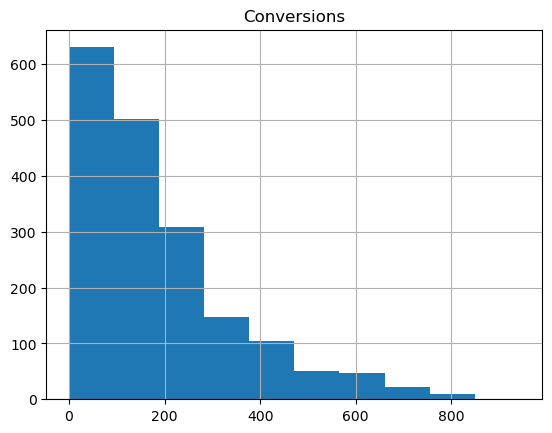

In [25]:
import matplotlib.pyplot as plt

df['conversions'].hist()
plt.title('Conversions')
plt.show()

<function matplotlib.pyplot.tight_layout(*, pad: 'float' = 1.08, h_pad: 'float | None' = None, w_pad: 'float | None' = None, rect: 'tuple[float, float, float, float] | None' = None) -> 'None'>

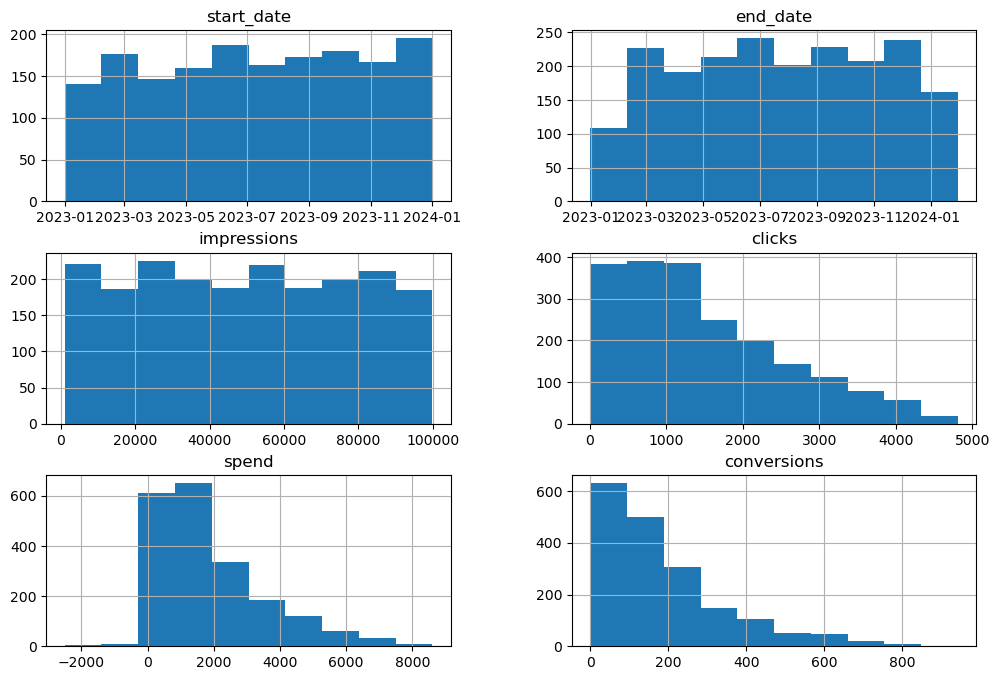

In [29]:
df.hist(figsize=(12,8))
plt.tight_layout

In [36]:
df.clicks

0        197
1         30
2        843
3       2019
4        169
        ... 
2015     586
2016     897
2017    1117
2018    2960
2019    1090
Name: clicks, Length: 2020, dtype: int64

In [34]:
def double_minus_one(x):
    return x*2-1

In [35]:
df.clicks.apply(double_minus_one)

0        393
1         59
2       1685
3       4037
4        337
        ... 
2015    1171
2016    1793
2017    2233
2018    5919
2019    2179
Name: clicks, Length: 2020, dtype: int64

In [47]:
df.groupby('channel').agg({'conversions':['mean','count','max','min'],'clicks':['mean','count','max','min']})

conversions                         clicks                
                  mean count    max  min         mean count   max min
channel                                                              
Email       183.173410   346  943.0  3.0  1493.168421   380  4812  26
Facebook    192.795082   366  788.0  1.0  1556.259259   405  4618  29
Google Ads  188.713846   325  803.0  2.0  1506.266667   360  4620  30
Instagram   181.911111   315  794.0  2.0  1443.662953   359  4574  16
TikTok      182.192000   375  760.0  1.0  1499.628916   415  4730  18

In [44]:
df.set_index('channel')

,campaign_id,campaign_name,start_date,end_date,impressions,clicks,spend,conversions,active,campaign_tag,season
channel,,,,,,,,,,,
TikTok,CMP-00001,Q4_Summer_CMP-00001,2023-11-24,2023-12-13,16795,197,102.82,20.0,True,TI,Summer
Facebook,CMP-00002,Q1_Launch_CMP-00002,2023-05-06,2023-05-12,1860,30,24.33,1.0,False,FA,Launch
Email,CMP-00003,Q3_Winter_CMP-00003,2023-12-13,2023-12-20,77820,843,1323.39,51.0,False,EM,Winter
TikTok,CMP-00004,Q1_BlackFriday_CMP-00004,NaT,2023-11-03,55886,2019,2180.38,135.0,False,TI,BlackFriday
Facebook,CMP-00005,Q2_Winter_CMP-00005,2023-04-22,2023-04-23,7265,169,252.44,30.0,True,FA,Winter
...,...,...,...,...,...,...,...,...,...,...,...
TikTok,CMP-00400,Q3_Summer_CMP-00400,2023-10-31,2023-11-13,30592,586,503.95,77.0,True,TI,Summer
Google Ads,CMP-01255,Q4_Summer_CMP-01255,2023-09-01,2023-09-26,20097,897,1641.00,162.0,False,GO,Summer
Instagram,CMP-01050,Q2_Launch_CMP-01050,2023-02-09,2023-02-21,33254,1117,883.82,214.0,False,IN,Launch


In [16]:
# ==========================================
# STEP 6: LOGICAL INTEGRITY (CLICKS vs IMPRESSIONS)
# ==========================================

impossible_mask = df['clicks'] > df['impressions']
print(df.loc[impossible_mask,['campaign_id','impressions','clicks']].head(3))

Empty DataFrame
Columns: [campaign_id, impressions, clicks]
Index: []


In [17]:
# ==========================================
# STEP 7: LOGICAL INTEGRITY (TIME TRAVEL)
# ==========================================

time_travel_mask = df['end_date'] < df['start_date']
print(df.loc[time_travel_mask,['campaign_id','start_date','end_date']].head(3))

df.loc[time_travel_mask, 'end_date'] = df.loc[time_travel_mask, 'start_date'] + pd.Timedelta(days=30)

print("FIX APPLIED")
print(df.loc[time_travel_mask,['campaign_id','start_date','end_date']].head(3))


   campaign_id start_date   end_date
23   CMP-00024 2023-05-06 2023-05-01
54   CMP-00055 2023-09-01 2023-08-27
71   CMP-00072 2023-02-01 2023-01-27
FIX APPLIED
   campaign_id start_date   end_date
23   CMP-00024 2023-05-06 2023-06-05
54   CMP-00055 2023-09-01 2023-10-01
71   CMP-00072 2023-02-01 2023-03-03


In [18]:
# ==========================================
# STEP 8: HANDLING OUTLIERS (WINSORIZING)
# ==========================================

Q1 = df['spend'].quantile(0.25)
Q3 = df['spend'].quantile(0.75)

IQR = Q3 - Q1
upper_limit = Q3 + (3 * IQR)

outlier_mask = df['spend'] > upper_limit
print(df.loc[outlier_mask,['campaign_id','spend']].head(3))

print("FIX APPLIED")
df.loc[outlier_mask, 'spend'] = upper_limit
print(df.loc[outlier_mask,['campaign_id','spend']].head(3))


     campaign_id      spend
789    CMP-00790  500000.00
1443   CMP-01444    8921.51
1460   CMP-01461  500000.00
FIX APPLIED
     campaign_id      spend
789    CMP-00790  8603.5375
1443   CMP-01444  8603.5375
1460   CMP-01461  8603.5375


In [19]:
# ==========================================
# STEP 9: STRING PARSING (FEATURE EXTRACTION)
# ==========================================

print(df['campaign_name'].head(3))

df['season'] = df['campaign_name'].str.extract(r'Q\d_([^_]+)_')

print("FIX APPLIED")

print(df[['campaign_name','season']].head(3))


0    Q4_Summer_CMP-00001
1    Q1_Launch_CMP-00002
2    Q3_Winter_CMP-00003
Name: campaign_name, dtype: object
FIX APPLIED
         campaign_name  season
0  Q4_Summer_CMP-00001  Summer
1  Q1_Launch_CMP-00002  Launch
2  Q3_Winter_CMP-00003  Winter
